<a id="1"></a> 
# <p style="background-color: #3498db; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);color: #ffffff; font-family: 'Arial', sans-serif; font-size: 2.5em; text-align: center; font-weight: 600;">Object Detection Using Adaptive Mask RCNN in Optical Remote Sensing Images</p> 



**This project aims to employ adaptive mask Region-based Convolutional Network (mask-RCNN) for multi-class object detection in remote sensing images, addressing challenges such as scale variability, small object size, and limited annotated data through transfer learning and fine-tuning, following the CRISP-DM methodology for systematic data mining and model development.**

<span style="font-size: 36px;">**I-Buisness Understanding**</span>



**Project Description**


-Object detection in remote sensing imagery is a critical yet challenging task due to the complex nature of these images, which often feature both well-defined and ambiguous objects against intricate backgrounds. Traditional methods for this task have limitations, leading to the exploration of deep learning techniques like **Convolutional Neural Networks (CNNs)**. 

While approaches like **R-CNN and Faster R-CNN** have improved detection accuracy, they suffer from multi-stage processing and slow speeds. Newer methods like YOLO and SSD offer real-time performance but struggle with small object detection and speed-accuracy trade-offs. Recent studies have explored techniques such as transfer learning and novel architectures like **Mask R-CNN**, showing significant improvements in detection accuracy and IOU metrics.

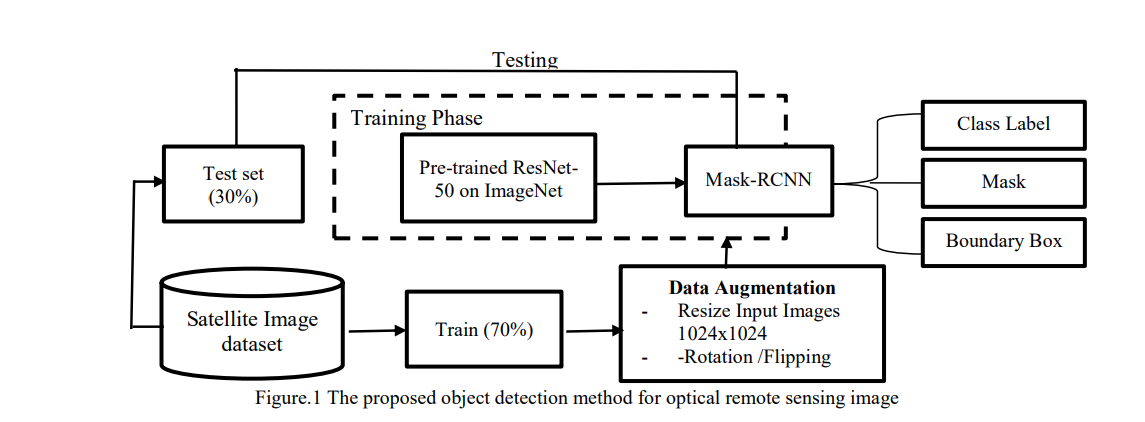

<span style="font-size: 36px;">**II-Data understanding**</span>

Source and Construction: The dataset is derived from very-high-resolution (VHR) remote sensing images compiled by Dr. Gong Cheng et al. at Northwestern Polytechnical University (NWPU).

**Purpose and Classes**: It is intended exclusively for research purposes and encompasses **10 distinct classes** of geospatial objects, including airplanes, ships, storage tanks, baseball diamonds, tennis courts, basketball courts, ground track fields, harbors, bridges, and vehicles.

**Image Distribution**: The dataset consists of a total of **800 VHR** remote sensing images, divided into two main categories: the "negative image set" containing **150 images** devoid of any target objects, and the "positive image set" comprising **650 images**, each containing at least one target object for detection.



**Annotation Process**: The images were sourced from Google Earth and the Vaihingen dataset, subsequently undergoing manual annotation by domain experts.


**Ground Truth Annotations**: Annotation information is provided in the "ground truth" folder, with **650 separate** text files corresponding to each image in the "positive image set."

Each text file contains ground truth bounding boxes represented in the format (x1,y1),(x2,y2),a, where (x1,y1) and (x2,y2) denote the top-left and bottom-right coordinates of the bounding box, respectively, and 'a' represents the object class.

<span style="font-size: 36px;">**III-Data preparation**</span>

### 1. Setup TorchVision and Detection Files & Python and ML Libraries for Object Detection 

In [1]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./



Cloning into 'vision'...
remote: Enumerating objects: 531480, done.
remote: Counting objects: 100% (45090/45090), done.
remote: Compressing objects: 100% (2080/2080), done.
remote: Total 531480 (delta 43045), reused 44919 (delta 42937), pack-reused 486390
Receiving objects: 100% (531480/531480), 1.00 GiB | 43.74 MiB/s, done.
Resolving deltas: 100% (496289/496289), done.
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [2]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch.optim as optim

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import pickle

### 2. Setting Up File Directories for Data 

In [3]:

files_dir = '/kaggle/input/rcnn-dataset/NWPU VHR-10 dataset/positive image set'
neg_dir = '/kaggle/input/rcnn-dataset/NWPU VHR-10 dataset /negative image set'
bbox_dir = '/kaggle/input/rcnn-dataset/NWPU VHR-10 dataset /ground truth'

### 3- Resource Retrieval Function (Data Cleaning)

In [4]:
def getressources():
        # Chemin vers votre répertoire contenant les fichiers
        repertoire = "/kaggle/input/rcnn-dataset/NWPU VHR-10 dataset/ground truth"

        # Initialisation des listes
        noms_fichiers = []
        box_data = []
        class_data = []

        # Parcours des fichiers dans le répertoire
        for nom_fichier in os.listdir(repertoire):
            chemin_fichier = os.path.join(repertoire, nom_fichier)
            # Vérification que le chemin correspond à un fichier et non à un répertoire
            if os.path.isfile(chemin_fichier):
                nom_sans_extension = os.path.splitext(nom_fichier)[0]
                with open(chemin_fichier, 'r') as f:
                    contenu_fichier = f.read()
                    noms_fichiers.append(nom_sans_extension)
                    lignes = contenu_fichier.strip().split('\n')
                    boxes = []
                    classes = []
                    for ligne in lignes:
                        elements = ligne.split(',')
                        box = [int(elem.strip("() ")) for elem in elements[:4]]
                        classe = int(elements[4])
                        boxes.append(box)
                        classes.append(classe)
                    box_data.append(boxes)
                    class_data.append(classes)
                
        return(noms_fichiers,box_data,class_data)

### 4-Custom Dataset Class for Object Detection 

In [5]:
class ImagesDataset(torch.utils.data.Dataset):
    
    def __init__(self, files_dir, width, height,ID,CLASS,BOX, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.bbox_dir= bbox_dir
        self.height = height
        self.width = width
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = ID
        self.box=BOX
        self.Class=CLASS
        
        
        # classes: 0 index is reserved for background
        self.classes= [_,1,2,3,4,5,6,7,8,9,10]
    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name +'.jpg')

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        #diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name + '.txt'
        annot_file_path = os.path.join(self.bbox_dir, annot_filename)
        bb=[]
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        # convert boxes into a torch.Tensor
        bbox=self.box[idx]
        for box in bbox:
            xmin_corr = (box[0]/wt)*self.width
            xmax_corr = (box[2]/wt)*self.width
            ymin_corr = (box[1]/ht)*self.height
            ymax_corr = (box[3]/ht)*self.height
            bb.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        boxes = torch.as_tensor(bb, dtype=torch.float32)

            
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(self.Class[idx], dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        image_id=idx
        target["image_id"] = image_id


        if self.transforms:

            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels.view(-1))
            
            img_res = sample['image']

            target['boxes'] = torch.Tensor(sample['bboxes'])
            target["labels"] = labels.view(-1)

        return torch.tensor(img_res), target

    def __len__(self):
        return len(self.imgs)

### 5-Data Augmentation & Transformation

In [6]:
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                            A.VerticalFlip(p=0.5),
                            A.Rotate(limit=(-90, 90), p=0.5),
                            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [7]:
ID,BOX,CLASS=getressources()

In [8]:
dataset = ImagesDataset(files_dir, 1024, 1024,ID,CLASS,BOX,transforms= get_transform(train=True))

In [9]:
dataset

In [10]:
print('length of dataset = ', len(dataset), '\n')

length of dataset =  650 



In [11]:
ls 


__notebook__.ipynb  coco_eval.py   engine.py      utils.py
__pycache__/        coco_utils.py  transforms.py  vision/


In [12]:
img, target = dataset[0]
print(img.shape, '\n',target)

torch.Size([3, 1024, 1024]) 
 {'boxes': tensor([[843.5410, 224.7805, 976.9967, 459.1670],
        [441.4951,  73.0056, 511.1606, 351.5797],
        [107.4360,  88.3752, 224.1049, 349.6585]]), 'labels': tensor([9, 9, 9]), 'area': tensor([31280.2227, 19407.0293, 30483.6309]), 'iscrowd': tensor([0, 0, 0]), 'image_id': 0}


###  Chekcking Plot Image with Bounding Boxes

In [13]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    img = img.permute(1, 2, 0)
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    boxes = target["boxes"]
    classes = target["labels"]
    
    for i in range(len(boxes)):
        box = boxes[i]
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        label = classes[i]
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        a.add_patch(rect)
        a.text(x, y, f'Class: {label.item()}', color='red', fontsize=12, backgroundcolor='white')

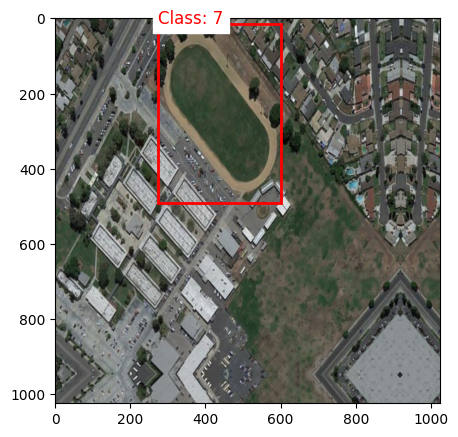

In [14]:
img, target = dataset[7]
plot_img_bbox(img, target)

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

<span style="font-size: 36px;">**IV-Modeling**</span>

### Object Detection Model Initialization

# 1st Strategy

We train the head layer for 30 epochs while freezing other layers with learning rate 0.005

In [16]:
 def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

**SGD Training**

In [17]:
num_epochs = 10

model = get_object_detection_model(11)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)


model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 154MB/s]


In [18]:
num_epochs = 30

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    #lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

NameError: name 'data_loader' is not defined

In [ ]:
pickle.dump(model, open('sgdstrategy1.pkl', 'wb'))

# 2nd Strategy

The convolution layer (+5) and convolution layer (+4) were trained for 30 epochs each using a learning rate 0.01and 0.001, respectively

In [ ]:
def get_object_detection_model_2nd_strategy(num_classes):
    # Load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Unfreeze layers for fine-tuning
    for name, param in model.named_parameters():
        if "layer4" in name:
            param.requires_grad = True  # Train layer 5 with learning rate 0.01
        elif "layer3" in name:
            param.requires_grad = True  # Train layer 4 with learning rate 0.001
        else:
            param.requires_grad = False  # Freeze other layers
    
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    
    return model

In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

**SGD**

In [ ]:
num_classes = 11

# get the model using our helper function
model = get_object_detection_model_2nd_strategy(num_classes)

# move model to the right device
model.to(device)

# Define the optimizer for layer 5
params_conv5 = [p for name, p in model.named_parameters() if 'layer4' in name and p.requires_grad]
optimizer_conv5 = optim.SGD(params_conv5, lr=0.01)


# Define the optimizer for layer 4
params_conv4 = [p for name, p in model.named_parameters() if 'layer3' in name and p.requires_grad]
optimizer_conv4 = optim.SGD(params_conv4, lr=0.001)



num_epochs_per_layer = 30

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                step_size=3,
#                                                gamma=0.1)

In [ ]:
# Train convolution layer (+5) for 30 epochs
for epoch in range(num_epochs_per_layer):
    train_one_epoch(model, optimizer_conv5, data_loader, device, epoch, print_freq=10)
    evaluate(model, data_loader_test, device=device)
    #lr_scheduler_conv5.step()

# Train convolution layer (+4) for 30 epochs
for epoch in range(num_epochs_per_layer):
    train_one_epoch(model, optimizer_conv4, data_loader, device, epoch, print_freq=10)
    evaluate(model, data_loader_test, device=device)
    #lr_scheduler_conv4.step()

**32% Precision at 0.5 threshold**

In [ ]:

modelSGD2 = pickle.load(open('/kaggle/input/models/strategy2.pkl', 'rb'))

# 3rd Strategy

The convolution layer (+3) were trained for 400 epochs with learning rate 0.001

In [ ]:
def get_object_detection_model_3rd_strategy(num_classes):
    # Load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Unfreeze layers for fine-tuning
    for name, param in model.named_parameters():
        if "layer2" in name:
            param.requires_grad = True
    
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    
    return model

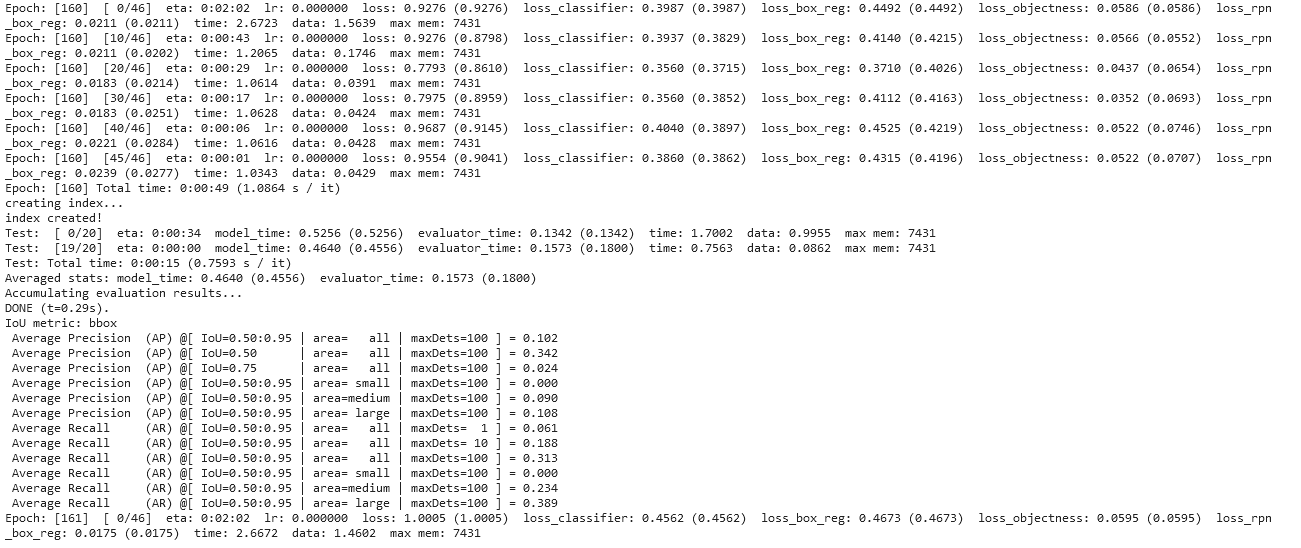

In [ ]:
dataset = ImagesDataset(files_dir, 1024, 1024,ID,CLASS,BOX,transforms= get_transform(train=True))
dataset_test = ImagesDataset(files_dir, 1024, 1024,ID,CLASS,BOX,transforms= get_transform(train=False))

### Object Detection Training and Testing

In [ ]:
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

<span style="font-size: 36px;">**V-Evaluation**</span>

In [ ]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

This function takes an input prediction with bounding boxes, confidence scores, and labels, applies NMS to remove redundant bounding boxes based on their IoU with a threshold, and returns the updated prediction.

In [ ]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    box=target["boxes"]
    Class=target["labels"]
    x, y, width, height  = box[0][0], box[0][1], box[0][2]-box[0][0], box[0][3]-box[0][1]
    print(x)
    print(y)
    print(Class)
    rect = patches.Rectangle((x,y),width, height,linewidth = 2,edgecolor = 'r',facecolor = 'none')
    # Draw the bounding box on top of the image
    a.add_patch(rect)
    plt.show()

# 1st Strategy with SGD

In [ ]:
img, target = dataset_test[9]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', prediction['labels'])
print('real #boxes: ', target['labels'])

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

# 2nd Strategy with SGD

In [ ]:
img, target = dataset_test[7]
# put the model in evaluation mode
modelSGD2.eval()
with torch.no_grad():
    prediction = modelSGD2([img.to(device)])[0]
    
print('predicted #boxes: ', prediction['labels'])
print('real #boxes: ', target['labels'])

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.1)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

# ------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# pick one image from the test set
img, target = dataset_test[6]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', prediction['labels'])
print('real #boxes: ', target['labels'])

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(img)
#     print(target['boxes'])
    for box in target['boxes']:
        x, y, w, h = box.cpu().numpy()  # Move the tensor to CPU and convert to NumPy array
        width, height  = w-x, h-y
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        a.add_patch(rect)
    plt.show()

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

In [ ]:
import torch
import cv2
import numpy as np

class MaskRCNNImagesDataset(torch.utils.data.Dataset):
    def __init__(self, files_dir, width, height,ID,CLASS,BOX, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.bbox_dir= bbox_dir
        self.height = height
        self.width = width
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = ID
        self.box=BOX
        self.Class=CLASS

    def __getitem__(self, idx):
        # Load image
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name + '.jpg')
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res /= 255.0
        
        # Load bounding boxes and class labels
        annot_filename = img_name + '.txt'
        annot_file_path = os.path.join(self.bbox_dir, annot_filename)
        bbox = self.box[idx]
        labels = torch.as_tensor(self.Class[idx], dtype=torch.int64)
        
        # Generate segmentation masks from bounding boxes
        masks = []
        for box in bbox:
            mask = np.zeros((self.height, self.width), dtype=np.uint8)
            xmin, ymin, xmax, ymax = box
            mask[ymin:ymax, xmin:xmax] = 1
            masks.append(mask)

        # Convert bounding boxes to PyTorch tensor
        wt = img.shape[1]
        ht = img.shape[0]
        bb = []
        for box in bbox:
            xmin_corr = (box[0] / wt) * self.width
            xmax_corr = (box[2] / wt) * self.width
            ymin_corr = (box[1] / ht) * self.height
            ymax_corr = (box[3] / ht) * self.height
            bb.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        boxes = torch.as_tensor(bb, dtype=torch.float32)

        # Compute areas and create target dictionary
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,  # Add segmentation masks to target dictionary
            "image_id": torch.tensor([idx]),  # Assuming you want to use idx as image_id
            "area": area,
            "iscrowd": iscrowd
        }

        return img_res, target

    def __len__(self):
        return len(self.imgs)
